# Análisis de NDVI - Ciudad Autónoma de Buenos Aires

Este notebook realiza un análisis espacial completo del Índice de Vegetación de Diferencia Normalizada (NDVI) utilizando imágenes Sentinel-2.

**Objetivos:**
1. Visualizar bandas espectrales individuales (Rojo e Infrarrojo Cercano)
2. Calcular y mapear el NDVI
3. Analizar estadísticas descriptivas
4. Identificar zonas de vegetación densa y escasa

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show, plotting_extent
from rasterio.features import shapes
import libpysal.weights as weights
import esda
from matplotlib.colors import LinearSegmentedColormap
import warnings

# Configuración de visualización
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
pd.set_option('display.precision', 3)
warnings.filterwarnings('ignore', category=RuntimeWarning)

C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


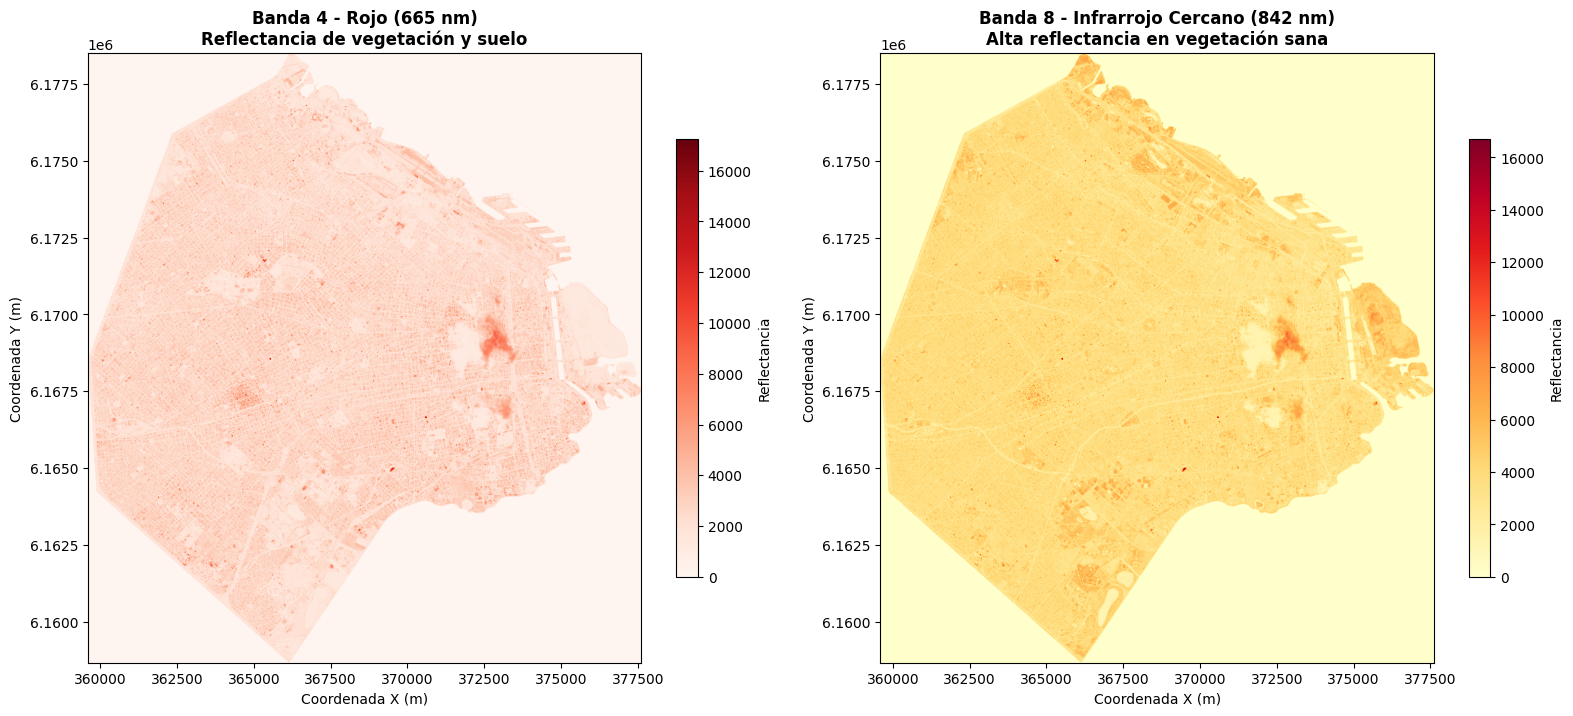

✓ Banda Roja: 1985 x 1803 píxeles
✓ Banda NIR:  1985 x 1803 píxeles


In [2]:
# Paths de datos
S2_B04_CABA = 'data/S2_B04_CABA.tif'
S2_B08_CABA = 'data/S2_B08_CABA.tif'

# Visualización de bandas espectrales
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Banda Roja (B04)
with rasterio.open(S2_B04_CABA) as src_b4:
    b4_data = src_b4.read(1)
    extent_b4 = plotting_extent(src_b4)
    
    im1 = axes[0].imshow(b4_data, cmap='Reds', extent=extent_b4)
    axes[0].set_title("Banda 4 - Rojo (665 nm)\nReflectancia de vegetación y suelo", 
                      fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Coordenada X (m)')
    axes[0].set_ylabel('Coordenada Y (m)')
    plt.colorbar(im1, ax=axes[0], label='Reflectancia', shrink=0.7)

# Banda Infrarrojo Cercano (B08)
with rasterio.open(S2_B08_CABA) as src_b8:
    b8_data = src_b8.read(1)
    extent_b8 = plotting_extent(src_b8)
    
    im2 = axes[1].imshow(b8_data, cmap='YlOrRd', extent=extent_b8)
    axes[1].set_title("Banda 8 - Infrarrojo Cercano (842 nm)\nAlta reflectancia en vegetación sana", 
                      fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Coordenada X (m)')
    axes[1].set_ylabel('Coordenada Y (m)')
    plt.colorbar(im2, ax=axes[1], label='Reflectancia', shrink=0.7)

plt.tight_layout()
plt.show()

print(f"✓ Banda Roja: {b4_data.shape[0]} x {b4_data.shape[1]} píxeles")
print(f"✓ Banda NIR:  {b8_data.shape[0]} x {b8_data.shape[1]} píxeles")

In [3]:
# Cálculo del NDVI con metadatos espaciales
with rasterio.open(S2_B04_CABA) as red, rasterio.open(S2_B08_CABA) as nir:
    b4 = red.read(1).astype('float32')
    b8 = nir.read(1).astype('float32')
    
    # Guardar metadatos para análisis posteriores
    transform = red.transform
    crs = red.crs
    extent = plotting_extent(red)
    
    # Calcular NDVI (usando np.nan para valores indefinidos)
    ndvi = np.where(
        (b8 + b4) == 0,
        np.nan,
        (b8 - b4) / (b8 + b4)
    )

# Estadísticas descriptivas
ndvi_valid = ndvi[~np.isnan(ndvi)]

print("=" * 60)
print("ESTADÍSTICAS DEL NDVI - CABA")
print("=" * 60)
print(f"Píxeles totales:        {ndvi.size:,}")
print(f"Píxeles válidos:        {ndvi_valid.size:,}")
print(f"Píxeles sin datos:      {np.isnan(ndvi).sum():,}")
print(f"\nMínimo:                 {ndvi_valid.min():.4f}")
print(f"Máximo:                 {ndvi_valid.max():.4f}")
print(f"Media:                  {ndvi_valid.mean():.4f}")
print(f"Mediana:                {np.median(ndvi_valid):.4f}")
print(f"Desviación estándar:    {ndvi_valid.std():.4f}")
print(f"\nPercentil 25:           {np.percentile(ndvi_valid, 25):.4f}")
print(f"Percentil 75:           {np.percentile(ndvi_valid, 75):.4f}")
print("=" * 60)

# Clasificación de cobertura
agua_urbano = np.sum((ndvi_valid >= -1) & (ndvi_valid < 0.2))
vegetacion_escasa = np.sum((ndvi_valid >= 0.2) & (ndvi_valid < 0.4))
vegetacion_moderada = np.sum((ndvi_valid >= 0.4) & (ndvi_valid < 0.6))
vegetacion_densa = np.sum((ndvi_valid >= 0.6) & (ndvi_valid <= 1))

print("\nCLASIFICACIÓN DE COBERTURA:")
print(f"  Agua/Urbano (-1 a 0.2):        {agua_urbano:,} píxeles ({100*agua_urbano/ndvi_valid.size:.1f}%)")
print(f"  Vegetación escasa (0.2-0.4):   {vegetacion_escasa:,} píxeles ({100*vegetacion_escasa/ndvi_valid.size:.1f}%)")
print(f"  Vegetación moderada (0.4-0.6): {vegetacion_moderada:,} píxeles ({100*vegetacion_moderada/ndvi_valid.size:.1f}%)")
print(f"  Vegetación densa (0.6-1.0):    {vegetacion_densa:,} píxeles ({100*vegetacion_densa/ndvi_valid.size:.1f}%)")
print("=" * 60)

ESTADÍSTICAS DEL NDVI - CABA
Píxeles totales:        3,578,955
Píxeles válidos:        2,036,637
Píxeles sin datos:      1,542,318

Mínimo:                 -0.4862
Máximo:                 1.0000
Media:                  0.1892
Mediana:                0.1370
Desviación estándar:    0.1556

Percentil 25:           0.0692
Percentil 75:           0.2794

CLASIFICACIÓN DE COBERTURA:
  Agua/Urbano (-1 a 0.2):        1,295,287 píxeles (63.6%)
  Vegetación escasa (0.2-0.4):   471,948 píxeles (23.2%)
  Vegetación moderada (0.4-0.6): 251,087 píxeles (12.3%)
  Vegetación densa (0.6-1.0):    18,315 píxeles (0.9%)


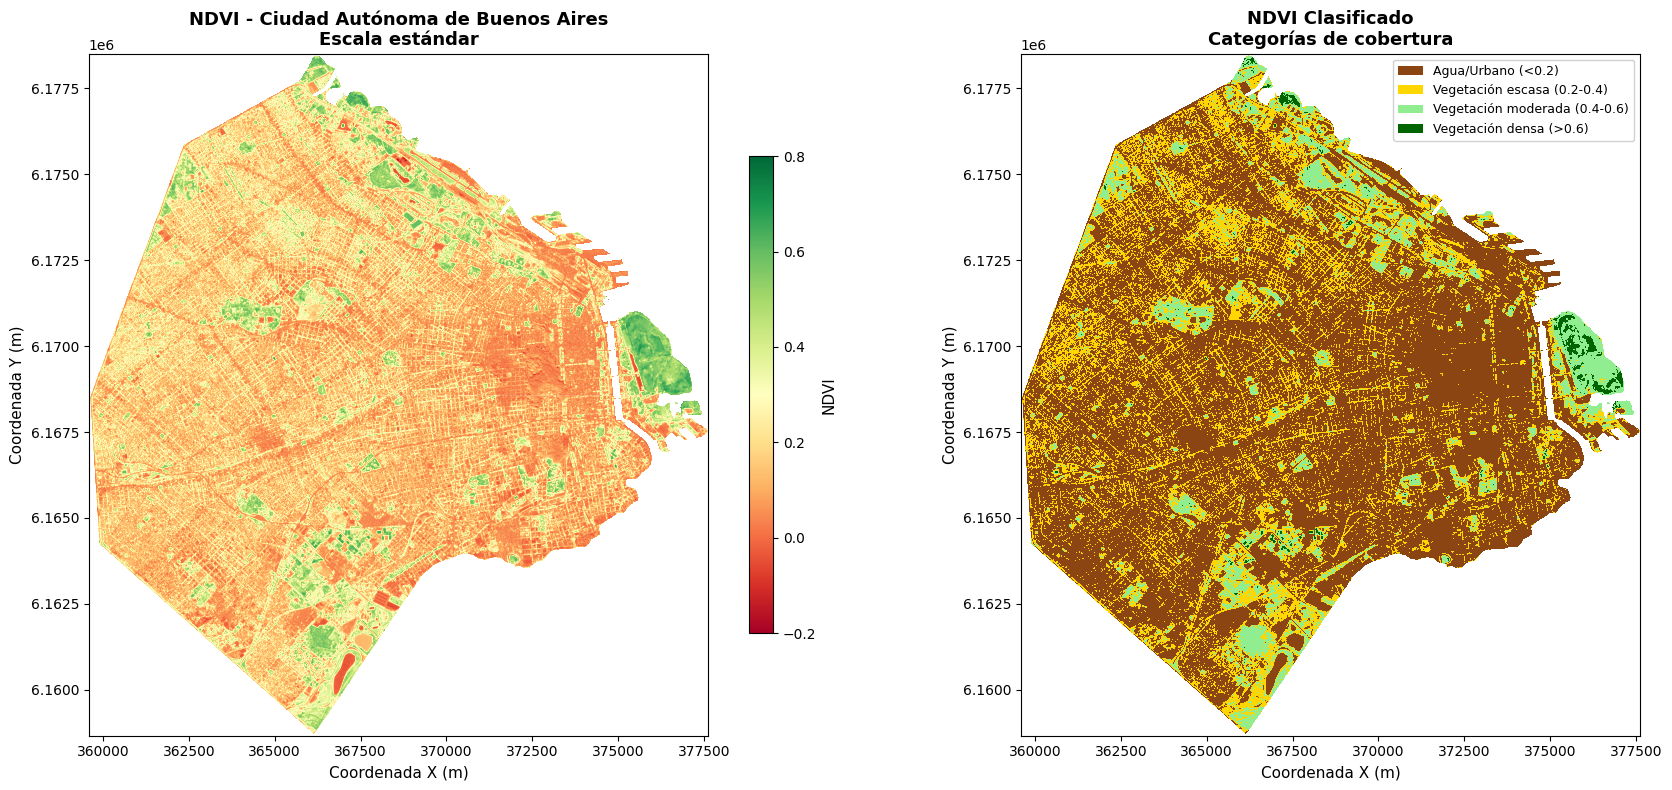

In [4]:
# Visualización mejorada del NDVI
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Mapa 1: NDVI con escala estándar
im1 = axes[0].imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.8, extent=extent)
axes[0].set_title("NDVI - Ciudad Autónoma de Buenos Aires\nEscala estándar", 
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Coordenada X (m)', fontsize=11)
axes[0].set_ylabel('Coordenada Y (m)', fontsize=11)
cbar1 = plt.colorbar(im1, ax=axes[0], shrink=0.7)
cbar1.set_label('NDVI', fontsize=11)

# Agregar líneas de referencia
axes[0].axhline(y=extent[2] + (extent[3]-extent[2])/2, color='white', 
                linestyle='--', linewidth=0.5, alpha=0.3)
axes[0].axvline(x=extent[0] + (extent[1]-extent[0])/2, color='white', 
                linestyle='--', linewidth=0.5, alpha=0.3)

# Mapa 2: NDVI clasificado
ndvi_classified = np.full_like(ndvi, np.nan)
ndvi_classified[(ndvi >= -1) & (ndvi < 0.2)] = 1    # Agua/Urbano
ndvi_classified[(ndvi >= 0.2) & (ndvi < 0.4)] = 2   # Vegetación escasa
ndvi_classified[(ndvi >= 0.4) & (ndvi < 0.6)] = 3   # Vegetación moderada
ndvi_classified[(ndvi >= 0.6) & (ndvi <= 1)] = 4    # Vegetación densa

colors = ['#8B4513', '#FFD700', '#90EE90', '#006400']
cmap_custom = LinearSegmentedColormap.from_list('ndvi_classes', colors, N=4)

im2 = axes[1].imshow(ndvi_classified, cmap=cmap_custom, vmin=0.5, vmax=4.5, extent=extent)
axes[1].set_title("NDVI Clasificado\nCategorías de cobertura", 
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Coordenada X (m)', fontsize=11)
axes[1].set_ylabel('Coordenada Y (m)', fontsize=11)

# Leyenda personalizada
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors[0], label='Agua/Urbano (<0.2)'),
    Patch(facecolor=colors[1], label='Vegetación escasa (0.2-0.4)'),
    Patch(facecolor=colors[2], label='Vegetación moderada (0.4-0.6)'),
    Patch(facecolor=colors[3], label='Vegetación densa (>0.6)')
]
axes[1].legend(handles=legend_elements, loc='upper right', fontsize=9, framealpha=0.9)

plt.tight_layout()
plt.show()

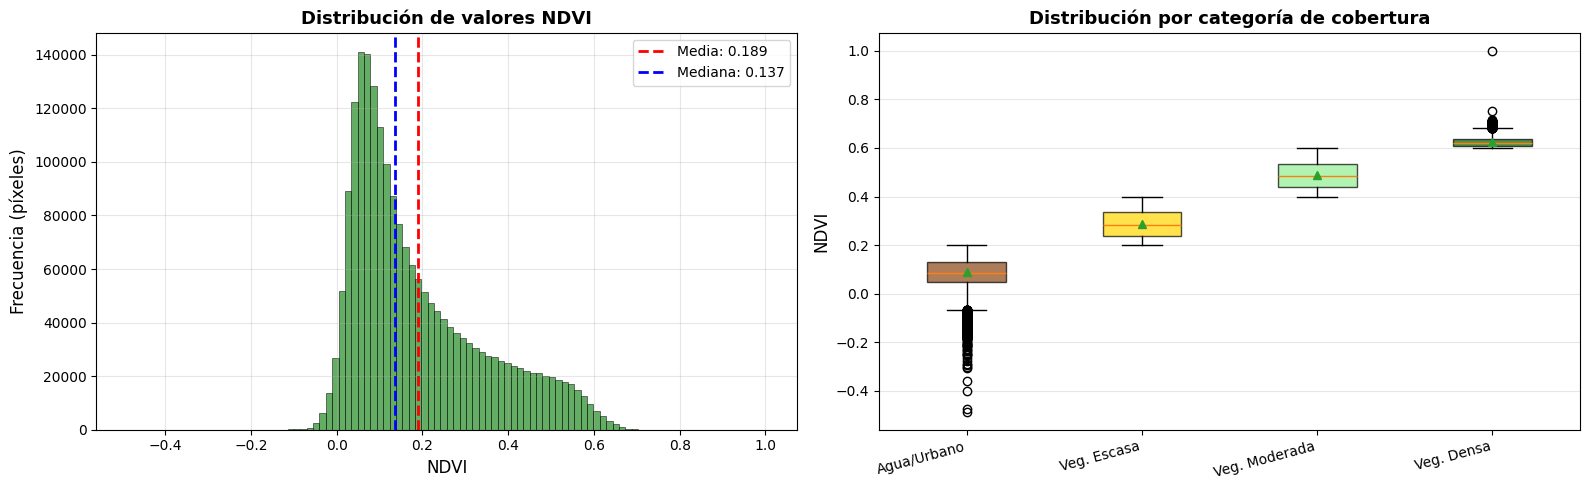

In [5]:
# Histograma y distribución del NDVI
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histograma
axes[0].hist(ndvi_valid, bins=100, color='forestgreen', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].axvline(ndvi_valid.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {ndvi_valid.mean():.3f}')
axes[0].axvline(np.median(ndvi_valid), color='blue', linestyle='--', linewidth=2, label=f'Mediana: {np.median(ndvi_valid):.3f}')
axes[0].set_xlabel('NDVI', fontsize=12)
axes[0].set_ylabel('Frecuencia (píxeles)', fontsize=12)
axes[0].set_title('Distribución de valores NDVI', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Box plot
box_data = [
    ndvi_valid[(ndvi_valid >= -1) & (ndvi_valid < 0.2)],
    ndvi_valid[(ndvi_valid >= 0.2) & (ndvi_valid < 0.4)],
    ndvi_valid[(ndvi_valid >= 0.4) & (ndvi_valid < 0.6)],
    ndvi_valid[(ndvi_valid >= 0.6) & (ndvi_valid <= 1)]
]

bp = axes[1].boxplot(box_data, labels=['Agua/Urbano', 'Veg. Escasa', 'Veg. Moderada', 'Veg. Densa'],
                     patch_artist=True, showmeans=True)

# Colorear cajas
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1].set_ylabel('NDVI', fontsize=12)
axes[1].set_title('Distribución por categoría de cobertura', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticklabels(['Agua/Urbano', 'Veg. Escasa', 'Veg. Moderada', 'Veg. Densa'], 
                        rotation=15, ha='right')

plt.tight_layout()
plt.show()

## Interpretación de Resultados

### ¿Qué es el NDVI?

El **Índice de Vegetación de Diferencia Normalizada (NDVI)** es un indicador de la presencia y salud de la vegetación:

- **Fórmula**: NDVI = (NIR - Rojo) / (NIR + Rojo)
- **Rango**: -1 a +1

### Interpretación de valores:

| Rango NDVI | Interpretación | Color en mapa |
|------------|----------------|---------------|
| < 0.2 | Agua, suelo desnudo, áreas urbanas | Marrón |
| 0.2 - 0.4 | Vegetación escasa, césped, arbustos dispersos | Amarillo |
| 0.4 - 0.6 | Vegetación moderada, parques urbanos | Verde claro |
| > 0.6 | Vegetación densa y saludable, bosques | Verde oscuro |

### Observaciones clave:

1. **Distribución espacial**: Las áreas verdes se concentran en parques y espacios públicos
2. **Heterogeneidad urbana**: CABA muestra gran variabilidad en cobertura vegetal
3. **Áreas de interés**: Los valores altos de NDVI indican zonas con vegetación densa que proveen servicios ecosistémicos importantes

In [6]:
# Exportar NDVI como GeoTIFF para análisis posteriores
output_path = 'data/NDVI_CABA.tif'

with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=ndvi.shape[0],
    width=ndvi.shape[1],
    count=1,
    dtype=ndvi.dtype,
    crs=crs,
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(ndvi, 1)
    dst.set_band_description(1, 'NDVI')

print(f"✓ NDVI exportado exitosamente a: {output_path}")
print(f"  - Dimensiones: {ndvi.shape[0]} x {ndvi.shape[1]} píxeles")
print(f"  - Sistema de coordenadas: {crs}")
print(f"  - Rango de valores: [{ndvi_valid.min():.4f}, {ndvi_valid.max():.4f}]")

✓ NDVI exportado exitosamente a: data/NDVI_CABA.tif
  - Dimensiones: 1985 x 1803 píxeles
  - Sistema de coordenadas: EPSG:32721
  - Rango de valores: [-0.4862, 1.0000]
